# Initial Setup

In [1]:
import os, time, math, pathlib
import numpy as np, pandas as pd
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

os.environ.setdefault("NCCL_P2P_LEVEL", "0")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", DEVICE)
torch.manual_seed(42)


Running on: cuda


In [2]:
class ParquetDataset(Dataset):
    def __init__(self, file_path, label_col):
        df = pd.read_parquet(file_path, engine="pyarrow")
        self.y = torch.tensor(df[label_col].values, dtype=torch.float32)
        self.X = torch.tensor(df.drop(columns=[label_col]).values, dtype=torch.float32)

    def __len__(self):  return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

import re, pathlib

DROP_PATTERNS = [
    r"_se$", r"^gamma_", r"^vega_", r"^theta$", r"^theta_",
    r"^price_se$", r"^rho_se$"
]
def is_drop(col): return any(re.search(p, col) for p in DROP_PATTERNS)

def clean_parquet(path):
    df = pd.read_parquet(path, engine="pyarrow")
    keep = [c for c in df.columns if not is_drop(c)]
    out  = pathlib.Path(path).with_stem(pathlib.Path(path).stem + "_clean")
    df[keep].to_parquet(out, index=False)
    print(f"✓ wrote {out} — kept {len(keep)} columns")
    return out

TRAIN_FILE = clean_parquet("Train.parquet")
VAL_FILE   = clean_parquet("Validation10k.parquet")
TEST_FILE  = clean_parquet("Test100M.parquet")
LABEL_COL  = "price"

train_ds = ParquetDataset(TRAIN_FILE, LABEL_COL)
val_ds   = ParquetDataset(VAL_FILE,   LABEL_COL)
test_ds  = ParquetDataset(TEST_FILE,  LABEL_COL)
print(f"train {len(train_ds):,}  val {len(val_ds):,}  test {len(test_ds):,}")


✓ wrote Train_clean.parquet — kept 16 columns
✓ wrote Validation10k_clean.parquet — kept 16 columns
✓ wrote Test100M_clean.parquet — kept 16 columns
train 5,000,000  val 500,000  test 500


In [3]:
WIDTH, LAYERS = 400, 6          # match paper default width sweep
INPUT_DIM = train_ds.X.shape[1]

class BasketNet(nn.Module):
    def __init__(self, in_dim, width, layers):
        super().__init__()
        blocks = [nn.Linear(in_dim, width), nn.ReLU()]
        for _ in range(layers - 1):
            blocks += [nn.Linear(width, width), nn.ReLU()]
        blocks.append(nn.Linear(width, 1))
        self.net = nn.Sequential(*blocks)
    def forward(self, x): return self.net(x)

def _run_epoch(model, loader, crit, opt=None):
    train = opt is not None
    model.train() if train else model.eval()
    tot, n = 0., 0
    for X, y in loader:
        X, y = X.to(DEVICE), y.to(DEVICE).unsqueeze(1)
        if train:
            opt.zero_grad(set_to_none=True)
            loss = crit(model(X), y); loss.backward(); opt.step()
        else:
            with torch.no_grad(): loss = crit(model(X), y)
        tot += loss.item() * X.size(0); n += X.size(0)
    return tot / n


In [4]:
def run_experiment(width=400, layers=6, batch=50_000,
                   epochs=10, lr=1e-3, seed=42, tag=None):
    torch.manual_seed(seed)
    tag = tag or f"w{width}_L{layers}_bs{batch}_lr{lr:g}"
    model = BasketNet(INPUT_DIM, width, layers).to(DEVICE)

    train_ld = DataLoader(train_ds, batch_size=batch, shuffle=True,  pin_memory=True)
    val_ld   = DataLoader(val_ds,   batch_size=batch, shuffle=False, pin_memory=True)
    test_ld  = DataLoader(test_ds,  batch_size=batch, shuffle=False, pin_memory=True)

    crit = nn.MSELoss()
    opt  = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

    tr_curve, va_curve = [], []
    for ep in range(1, epochs+1):
        tr = _run_epoch(model, train_ld, crit, opt)
        va = _run_epoch(model, val_ld,   crit, None)
        tr_curve.append(tr); va_curve.append(va)
        print(f"[{tag}] {ep:02d}/{epochs} train {tr:.6f} val {va:.6f}")

    # learning curve
    plt.figure(figsize=(6,4))
    plt.plot(tr_curve, label="train"); plt.plot(va_curve, label="val")
    plt.yscale("log"); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.legend()
    plt.title(f"Learning curve ({tag})"); plt.show()

    # test metrics + histogram
    model.eval(); preds, truths = [], []
    with torch.no_grad():
        for X, y in test_ld:
            preds.append(model(X.to(DEVICE)).cpu()); truths.append(y)
    err = torch.cat(preds).squeeze() - torch.cat(truths)
    print(f"[{tag}] RMSE {err.pow(2).mean().sqrt():.6f}  MAE {err.abs().mean():.6f}")
    plt.figure(figsize=(6,4)); plt.hist(err, bins=100, density=True, edgecolor="black")
    plt.title(f"Test error ({tag})"); plt.xlabel("prediction − truth"); plt.show()

    torch.save(model.state_dict(), f"model_{tag}.pt")


# 4x400

[w400_L4_50ep] 01/200 train 669706.051154 val 1080.302783
[w400_L4_50ep] 02/200 train 4951.474456 val 1457.929211
[w400_L4_50ep] 03/200 train 817.952694 val 605.971936
[w400_L4_50ep] 04/200 train 664.954490 val 589.738422
[w400_L4_50ep] 05/200 train 1039.350829 val 740.933148
[w400_L4_50ep] 06/200 train 4972.939149 val 586.917371
[w400_L4_50ep] 07/200 train 673.211241 val 12667.764941
[w400_L4_50ep] 08/200 train 7634.191602 val 827.417047
[w400_L4_50ep] 09/200 train 639.514775 val 591.635980
[w400_L4_50ep] 10/200 train 644.204173 val 834.205914
[w400_L4_50ep] 11/200 train 4755.072521 val 615.351917
[w400_L4_50ep] 12/200 train 634.526536 val 595.901428
[w400_L4_50ep] 13/200 train 606.857972 val 645.571667
[w400_L4_50ep] 14/200 train 572.821317 val 524.656769
[w400_L4_50ep] 15/200 train 518.208209 val 493.735019
[w400_L4_50ep] 16/200 train 537.689722 val 464.380911
[w400_L4_50ep] 17/200 train 459.481718 val 497.380466
[w400_L4_50ep] 18/200 train 665.090356 val 663.701318
[w400_L4_50ep] 1

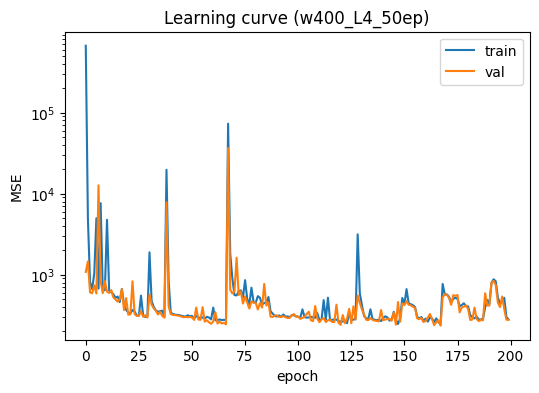

[w400_L4_50ep] RMSE 16.492340  MAE 12.291014


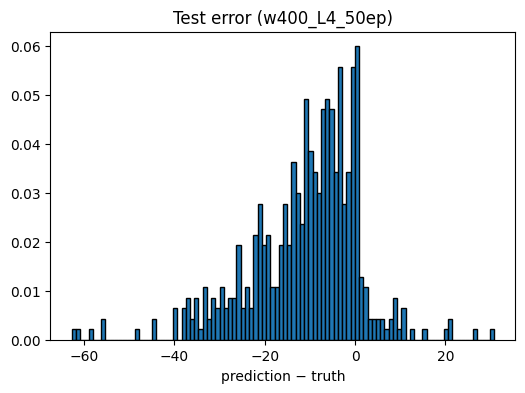

In [5]:
run_experiment(width=400, layers=4, epochs=200, tag="w400_L4_50ep")

# 5x400

[w400_L5_50ep] 01/50 train 46162.827960 val 34016.475195
[w400_L5_50ep] 02/50 train 2078.014990 val 713.906799
[w400_L5_50ep] 03/50 train 715.567950 val 631.661639
[w400_L5_50ep] 04/50 train 648.298358 val 580.912811
[w400_L5_50ep] 05/50 train 22713.846357 val 620.450061
[w400_L5_50ep] 06/50 train 740.864409 val 863.751569
[w400_L5_50ep] 07/50 train 674.750490 val 591.226685
[w400_L5_50ep] 08/50 train 619.939572 val 574.762872
[w400_L5_50ep] 09/50 train 624.958344 val 592.888379
[w400_L5_50ep] 10/50 train 658.375191 val 576.315240
[w400_L5_50ep] 11/50 train 747.578356 val 1470.020276
[w400_L5_50ep] 12/50 train 592.019879 val 527.724265
[w400_L5_50ep] 13/50 train 563.627401 val 529.409445
[w400_L5_50ep] 14/50 train 544.298958 val 467.300360
[w400_L5_50ep] 15/50 train 442.427910 val 478.714319
[w400_L5_50ep] 16/50 train 34661.487018 val 36339.451172
[w400_L5_50ep] 17/50 train 7735.159193 val 470.339676
[w400_L5_50ep] 18/50 train 509.964787 val 467.537860
[w400_L5_50ep] 19/50 train 496.68

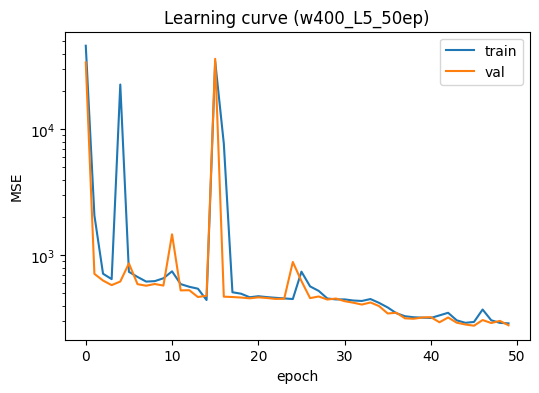

[w400_L5_50ep] RMSE 20.323961  MAE 14.590209


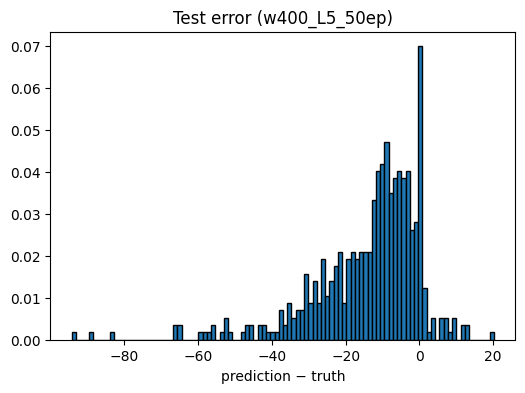

In [28]:
run_experiment(width=400, layers=5, epochs=50, tag="w400_L5_50ep")

# 6x400

[w400_L6_50ep] 01/50 train 39477.573188 val 681.773505
[w400_L6_50ep] 02/50 train 688.322422 val 614.488879
[w400_L6_50ep] 03/50 train 682.553353 val 845.568176
[w400_L6_50ep] 04/50 train 648.247341 val 611.518225
[w400_L6_50ep] 05/50 train 732.563734 val 631.353809
[w400_L6_50ep] 06/50 train 901.009402 val 623.060052
[w400_L6_50ep] 07/50 train 890.034142 val 604.710321
[w400_L6_50ep] 08/50 train 632.747933 val 590.425500
[w400_L6_50ep] 09/50 train 621.272213 val 572.757568
[w400_L6_50ep] 10/50 train 619.678326 val 581.747211
[w400_L6_50ep] 11/50 train 669.748412 val 596.334784
[w400_L6_50ep] 12/50 train 583.426677 val 635.224567
[w400_L6_50ep] 13/50 train 574.108518 val 566.596985
[w400_L6_50ep] 14/50 train 589.989066 val 603.022528
[w400_L6_50ep] 15/50 train 565.684775 val 555.506616
[w400_L6_50ep] 16/50 train 1335.360436 val 590.599530
[w400_L6_50ep] 17/50 train 635.437860 val 568.823749
[w400_L6_50ep] 18/50 train 2282.339084 val 588.445752
[w400_L6_50ep] 19/50 train 618.856826 val 

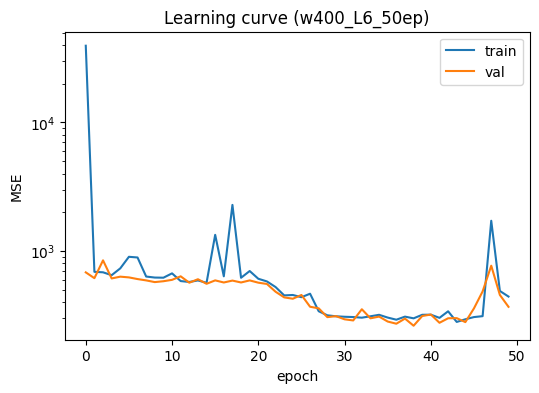

[w400_L6_50ep] RMSE 22.800817  MAE 16.129181


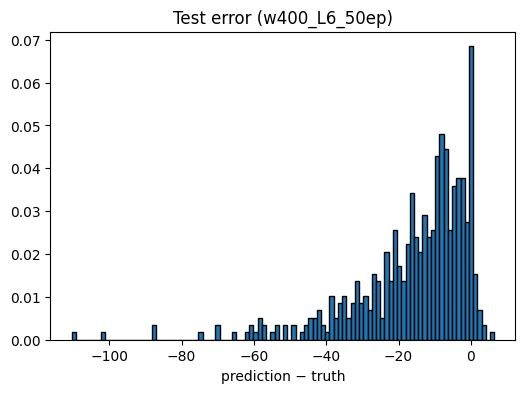

In [29]:
run_experiment(width=400, layers=6, epochs=50, tag="w400_L6_50ep")

# 5 x 600

[w600_L5_50ep] 01/50 train 312809.624564 val 11785.231641
[w600_L5_50ep] 02/50 train 1494.261370 val 914.391919
[w600_L5_50ep] 03/50 train 656.884818 val 620.642719
[w600_L5_50ep] 04/50 train 1541.814654 val 623.566718
[w600_L5_50ep] 05/50 train 676.800544 val 796.789569
[w600_L5_50ep] 06/50 train 650.235139 val 789.160516
[w600_L5_50ep] 07/50 train 1059.178787 val 614.996967
[w600_L5_50ep] 08/50 train 43653.888963 val 586957.781250
[w600_L5_50ep] 09/50 train 15769.444671 val 657.384485
[w600_L5_50ep] 10/50 train 624.553668 val 611.603027
[w600_L5_50ep] 11/50 train 635.978099 val 614.410767
[w600_L5_50ep] 12/50 train 1479.197198 val 726.306836
[w600_L5_50ep] 13/50 train 673.595508 val 622.380542
[w600_L5_50ep] 14/50 train 653.091336 val 615.057263
[w600_L5_50ep] 15/50 train 733.696769 val 607.818103
[w600_L5_50ep] 16/50 train 643.818474 val 603.156372
[w600_L5_50ep] 17/50 train 1276.071243 val 3721.035815
[w600_L5_50ep] 18/50 train 756.587998 val 647.328503
[w600_L5_50ep] 19/50 train 6

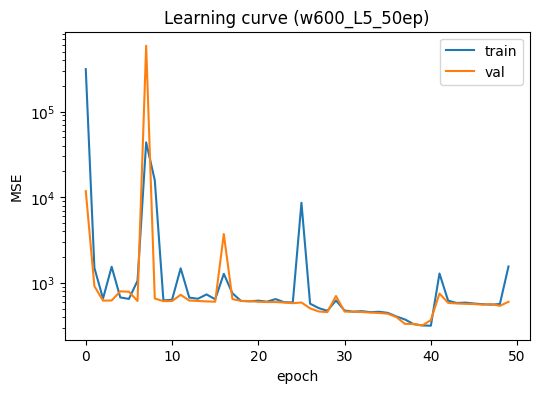

[w600_L5_50ep] RMSE 18.067879  MAE 11.877917


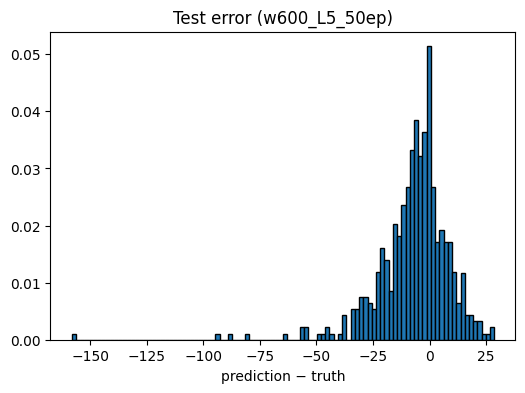

In [30]:
run_experiment(width=600, layers=5, epochs=50, tag="w600_L5_50ep")

# 6 x 500

[w500_L6_50ep] 01/50 train 31555.495663 val 672.584271
[w500_L6_50ep] 02/50 train 9764.965813 val 662.389154
[w500_L6_50ep] 03/50 train 629.945167 val 619.922156
[w500_L6_50ep] 04/50 train 802.982641 val 653.059869
[w500_L6_50ep] 05/50 train 624.994863 val 628.059125
[w500_L6_50ep] 06/50 train 623.293369 val 617.120361
[w500_L6_50ep] 07/50 train 2377.887338 val 638.096631
[w500_L6_50ep] 08/50 train 654.070366 val 621.073065
[w500_L6_50ep] 09/50 train 615.336545 val 617.719543
[w500_L6_50ep] 10/50 train 614.576842 val 596.893262
[w500_L6_50ep] 11/50 train 935.564871 val 615.194379
[w500_L6_50ep] 12/50 train 907.185579 val 604.916315
[w500_L6_50ep] 13/50 train 604.153762 val 595.841144
[w500_L6_50ep] 14/50 train 724.541833 val 591.374982
[w500_L6_50ep] 15/50 train 762.263260 val 593.446967
[w500_L6_50ep] 16/50 train 619.005313 val 581.275122
[w500_L6_50ep] 17/50 train 684.980687 val 597.942474
[w500_L6_50ep] 18/50 train 603.542445 val 576.774939
[w500_L6_50ep] 19/50 train 662.897547 val 

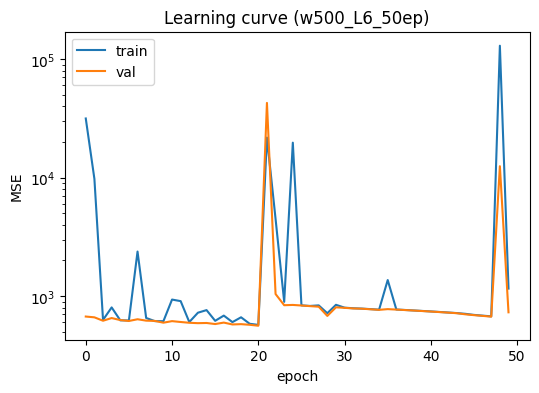

[w500_L6_50ep] RMSE 30.752214  MAE 19.448496


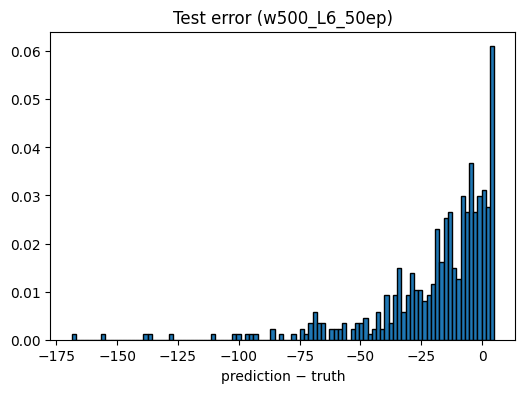

In [31]:
run_experiment(width=500, layers=6, epochs=50, tag="w500_L6_50ep")

# 4 x 750

[w750_L4_50ep] 01/50 train 2873453.135674 val 2904.599170
[w750_L4_50ep] 02/50 train 1577.902717 val 912.709570
[w750_L4_50ep] 03/50 train 10427.399070 val 90547.942969
[w750_L4_50ep] 04/50 train 6256.628586 val 647.688214
[w750_L4_50ep] 05/50 train 4764.974099 val 1110.574683
[w750_L4_50ep] 06/50 train 718.646974 val 605.701862
[w750_L4_50ep] 07/50 train 1105.653762 val 603.183521
[w750_L4_50ep] 08/50 train 645.939445 val 606.646228
[w750_L4_50ep] 09/50 train 740.461953 val 570.441052
[w750_L4_50ep] 10/50 train 1817.782890 val 635.111810
[w750_L4_50ep] 11/50 train 2055.917362 val 535.172736
[w750_L4_50ep] 12/50 train 678.957551 val 743.248944
[w750_L4_50ep] 13/50 train 2407.291035 val 2259.926001
[w750_L4_50ep] 14/50 train 644.260213 val 591.105469
[w750_L4_50ep] 15/50 train 590.550205 val 468.223184
[w750_L4_50ep] 16/50 train 456.913649 val 441.004407
[w750_L4_50ep] 17/50 train 1032.913976 val 488.215878
[w750_L4_50ep] 18/50 train 453.735760 val 407.672711
[w750_L4_50ep] 19/50 train 

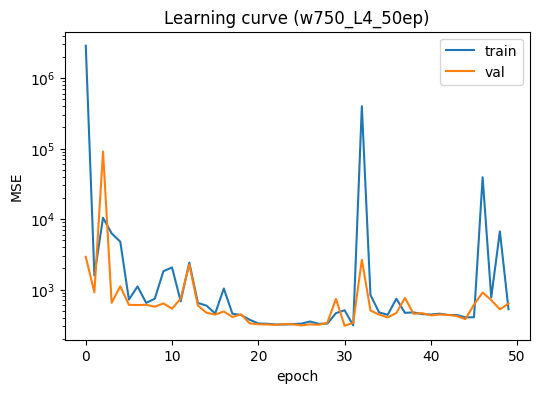

[w750_L4_50ep] RMSE 24.095617  MAE 15.041619


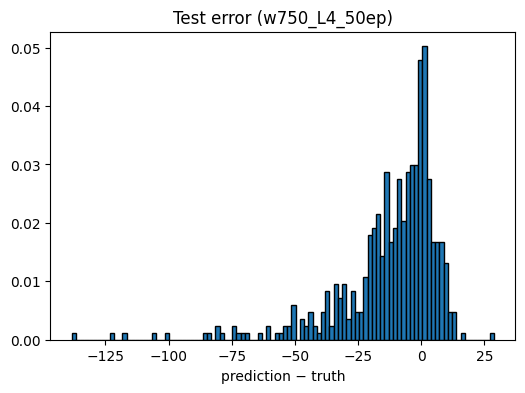

In [32]:
run_experiment(width=750, layers=4, epochs=50, tag="w750_L4_50ep")

# Following Exactly as the Paper = Larger Ephocs

In [5]:
from tqdm.auto import tqdm

def run_experiment(width=400, layers=6, batch=50_000,
                   n_updates=1_000_000,  # ← keep using “updates” as unit
                   lr=1e-3, seed=42, tag=None):

    # ── bookkeeping (unchanged) ───────────────────────────────────────
    torch.manual_seed(seed)
    tag  = tag or f"{len(train_ds)//1_000_000}m-{batch//1_000}k-{width}x{layers}"
    model, crit = BasketNet(INPUT_DIM, width, layers).to(DEVICE), nn.MSELoss()
    opt   = optim.Adam(model.parameters(), lr=lr)

    train_ld = DataLoader(train_ds, batch_size=batch, shuffle=True,  pin_memory=True)
    test_ld  = DataLoader(val_ds,   batch_size=len(val_ds), shuffle=False, pin_memory=True)

    updates_per_epoch = math.ceil(len(train_ds) / batch)
    epochs            = math.ceil(n_updates / updates_per_epoch)

    print(f"[{tag}] training for ≈{n_updates:,} updates "
          f"({epochs} epochs × {updates_per_epoch} batches)")

    # ── progress bar ─────────────────────────────────────────────────
    pbar = tqdm(total=n_updates, unit="upd", colour="#4caf50",
                bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} • {elapsed} "
                        "• ETA: {remaining} • {postfix}")

    global_step, tr_curve, te_curve = 0, [], []
    for ep in range(epochs):
        for X, y in train_ld:
            global_step += 1
            X, y = X.to(DEVICE), y.to(DEVICE).unsqueeze(1)

            opt.zero_grad(set_to_none=True)
            loss = crit(model(X), y); loss.backward(); opt.step()

            # update bar & record loss
            tr_curve.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.3e}"})
            pbar.update(1)

            if global_step >= n_updates:
                break

        # optional: epoch-wise validation
        if global_step >= n_updates: break

    pbar.close()            # freeze the bar at 100 %

    # ── quick test loss so you see something at the end (unchanged) ──
    with torch.no_grad():
        Xt, yt = next(iter(test_ld))
        err = model(Xt.to(DEVICE)).cpu() - yt.unsqueeze(1)
    print(f"final test RMSE = {err.pow(2).mean().sqrt():.6f}")


## 400 x 4

In [10]:
run_experiment(width=400, layers=4, batch=1_500_000, n_updates=400)

-1500k-400x4] training for ≈400 updates (100 epochs × 4 batches)


  0%|          | 0/400 • 00:00 • ETA: ? • 

KeyboardInterrupt: 

## 400 x 5 

In [ ]:
run_experiment(width=400, layers=5, batch=50_000, n_updates=1_000_000)

## 400 x 6

In [ ]:
run_experiment(width=400, layers=6, batch=50_000, n_updates=1_000_000)